In [1]:
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import scipy.sparse as sparse
from gprofiler import GProfiler
import matplotlib.pyplot as plt
import GmGM
import math
import BiGLasso_Methods as bg
import scipy.stats as stats

Single-cell eQTL mapping identifies cell type-specific genetic control of autoimmune disease

In [2]:
# Load the data in backed mode
adata = ad.read_h5ad("data/million-cell/eQTLAutoimmune.h5ad", backed=True, as_sparse=True)
adata

AnnData object with n_obs × n_vars = 1248980 × 36571 backed at 'data/million-cell/eQTLAutoimmune.h5ad'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_azimuth_spca', 'X_azimuth_umap', 'X_harmony', 'X_pca', '

In [3]:
var_cutoff = adata.var['vst.variance.standardized'].sort_values(ascending=False)[2200]
var_cutoff

1.1061691362823929

In [4]:
genes_to_keep = (adata.var['vst.mean'] > 0) & (adata.var['vst.variance.standardized'] > var_cutoff)
cells_to_keep = (adata.obs['nCount_RNA'] > 0)
adata = adata[cells_to_keep, genes_to_keep]
adata

View of AnnData object with n_obs × n_vars = 1248980 × 2200 backed at 'data/million-cell/eQTLAutoimmune.h5ad'
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'donor_id', 'pool_number', 'predicted.celltype.l2', 'predicted.celltype.l2.score', 'age', 'organism_ontology_term_id', 'tissue_ontology_term_id', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'cell_type_ontology_term_id_colors', 'default_embedding', 'schema_version', 'title'
    obsm: 'X_azimuth_spca', 'X_azimuth_umap', 'X_harmony', 'X_

In [5]:
dataset = GmGM.Dataset( # flipping in hopes it will prevent strange kernel crash
    dataset={"data": adata.X[:, :]},
    structure={"data": ("cell", "gene")}
)
dataset

Dataset(
	data: ('cell', 'gene')
)
Axes(
	gene: 2200
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
	cell: 1248980
		Prior: None
		Gram: Not calculated
		Eig: Not calculated
)

In [6]:
output = GmGM.GmGM(
    dataset,
    #to_keep={"cell": 0, "gene": 10},
    #threshold_method="overall-col-weighted",
    threshold_method="bonferroni",
    to_keep={"cell": 0, "gene": 0.05},
    min_edges={"cell": 0, "gene": 0},
    n_comps=50,
    verbose=True,
    centering_method=None,
    use_nonparanormal_skeptic=True,
    nonparanormal_evec_backend="COCA",
    readonly=False,
    calculate_explained_variance=True,
    #_assume_sparse=True,
    batch_size=1000
)

Centering...
Calculating eigenvectors...
	by calculating left eigenvectors and applying a rank-one update...
		Computing sparse normal map for axis='cell'...
		...Done computing sparse normal map
		Explained variance for axis='cell': 50.1170%
		Computing sparse normal map for axis='gene'...
		...Done computing sparse normal map
		Explained variance for axis='gene': 56.0291%
Calculating eigenvalues...
@0: 437837656.56057876 (-1796.8744436968539 + 437839453.4350225 + 0) ∆inf
Converged! (@19: 219545349.60366392)
Recomposing sparse precisions...


/Users/baileyandrew/mambaforge/envs/cnr-colab/lib/python3.9/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Done!


In [7]:
(output.precision_matrices['gene'].data > 0).any()

True

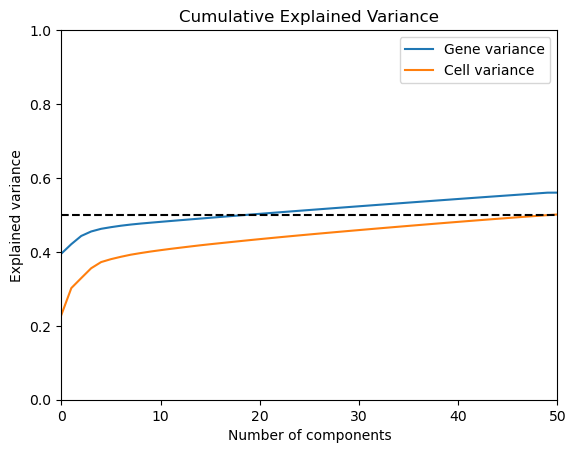

In [12]:
fig, ax = plt.subplots()

# Plot cumulative eigenvalues
ax.plot((output.es['gene'] / output.total_variance['gene']).cumsum(), label="Gene variance")
ax.plot((output.es['cell'] / output.total_variance['cell']).cumsum(), label="Cell variance")
ax.set_title("Cumulative Explained Variance")
ax.legend()
ax.set_xlabel("Number of components")
ax.set_ylabel("Explained variance")

# Explained variance cutoff
# ax.axhline(1/3, color='k', linestyle='--')
ax.axhline(1/2, color='k', linestyle='--')
# ax.axhline(0.8, color='k', linestyle='--')


ax.set_ylim(0, 1)
ax.set_xlim(0, output.es['gene'].shape[0] - 1)

fig.savefig("out-figs/million-cell-explained-variance.pdf", bbox_inches='tight', dpi=300)

In [9]:
sparse.save_npz(
    "out/million-cell-genes.npz", output.precision_matrices['gene']
)

In [10]:
adata.var_names.to_series().to_csv("out/million-cell-genes.csv", index=False)

In [11]:
sparse.load_npz("out/million-cell-genes.npz")

<2200x2200 sparse array of type '<class 'numpy.float32'>'
	with 8090 stored elements in Compressed Sparse Row format>